## SIAC filtering with FBP on noiseless Phantom

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import odl

import sys
sys.path.append("..")

from src.tomo import (
    make_space_2d,
    shepp_logan_2d,
    parallel_geom_2d,
    ray_transform_2d,
    reconstruct_bp,
    reconstruct_fbp,
)


### 2D Shepp Logan Phantom test

/home/ahopkins/KTH_TTMAM/MEX/odl_xray/venv/lib/python3.10/site-packages/odl/util/utility.py:1398: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_requirements


<Figure size 640x480 with 0 Axes>

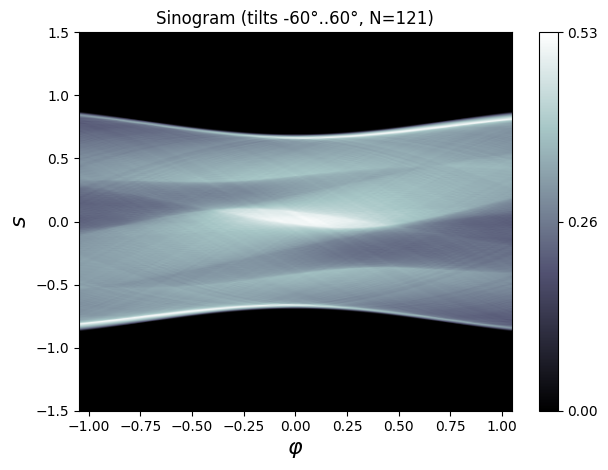

<Figure size 640x480 with 0 Axes>

In [2]:
space = make_space_2d(Nx=256, Ny=256, domain=[-1, 1, -1, 1])
phantom = shepp_logan_2d(space)

angular_coverage=(-60,60)
step = 1
geom = parallel_geom_2d(angular_coverage=angular_coverage, step=step, 
                        det_range=(-1.5, 1.5), det_count=400)
A = ray_transform_2d(space, geom)

sino = A(phantom)

bp  = reconstruct_bp(sino, A)

filter_used = "Ram-Lak"
fbp = reconstruct_fbp(sino, A, filter_name=filter_used)

phantom.show(title="Shepp-Logan phantom")
# plt.imshow(phantom, cmap='gray')
# plt.title("Shepp-Logan phantom")
# plt.axis("off")

sino.show(title=f"Sinogram (tilts {angular_coverage[0]}°..{angular_coverage[1]}°, N={int((angular_coverage[1] - angular_coverage[0]) / step) + 1})")
plt.show()
# plt.figure(figsize=(6,4))
# plt.imshow(sino, cmap="gray", aspect="auto")
# plt.title(f"Sinogram (tilts {angular_coverage[0]}°..{angular_coverage[1]}°, N={int((angular_coverage[1] - angular_coverage[0]) / step) + 1})")
# plt.axis("off")
# plt.show()


### Fourier SIAC filter with the FBP

**Regular FBP**
\begin{align*}
    \text{FBP} = A^* \mathcal{F}^{-1}\big[ |\omega|W(\omega) \mathcal{F}[\cdot] \big]
\end{align*}

Where $A^*$ is the adjoint to the X-ray transform, $\mathcal{F}$ is the Fourier transform and $W$ is a window (e.g. Shepp-Logan or Hann).

**FBP with SIAC**
\begin{align*}
    \text{FBP} = A^* \mathcal{F}^{-1}\big[ \underbrace{|\omega|W(\omega)}_{\text{standard FBP}} \underbrace{\widehat{S}(\omega)}_{\text{SIAC}} \mathcal{F}[\cdot] \big]
\end{align*}

**Note** Much code reused from Jennifer Ryans notebook: 
$\texttt{"FourierFilterIntro-Entire.ipynb"}$

A **sepereable** 2D frequency filter has the form:
$$
    \widehat{S}(\omega_x, \omega_y) = \widehat{S}_x(\omega_x) \cdot \widehat{S}_y(\omega_y)
$$
so it can be interpreted as applying a 1D filter in the $x$-direction and a 1D filter in $y$-direction (in the Fourier domain).

We **pad** the image before FFT-based filtering to avoid edge artifacts. FFT-based convolution assumes the input is periodic, meaning the left/right and top/bottom edges are implicitly “wrapped together”. Padding creates a buffer region so the effective convolution support does not reach the artificial periodic boundary, and we then crop back to the original field of view.

The padding itself only has to be slightly larger than the effective support of the SIAC kernel (radius). Since it is a B-spline of order $n$, it has support of width $n+1$, with the shifts $\gamma = 0, \ldots, r$ spanning a range of length $\sim r$. Thus we pad a distance of
$$
    R_{\text{pad}} \approx \frac{r+n+1}{2}
$$
in grid voxels (approximately the radius of the kernel).

### Fourier Form of Filter

The Fourier Form of the filter consisting of $r+1$ B-Splines of order $n$ is 
$$\sigma(\omega_n) = \left(\frac{\sin(\omega_n/2)}{\omega_n/2}\right)^n\left(c_0 + 2\sum_{\gamma = 0}^r\, c_\gamma \cos(\gamma\omega_n))\right)$$

### Comparing results of the Shepp-Logan Phantom

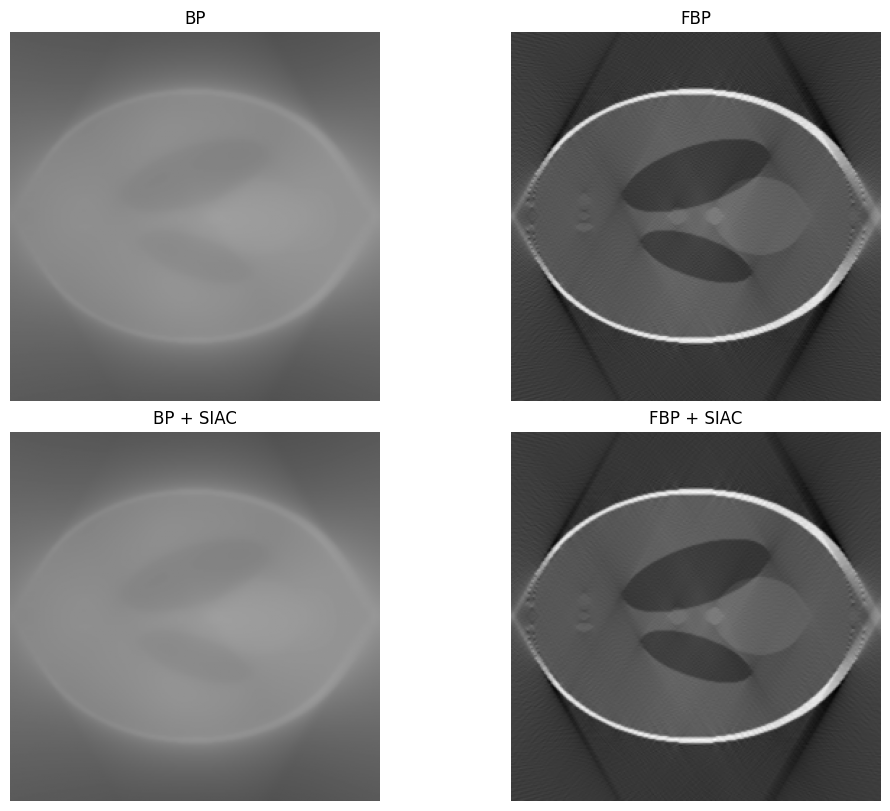

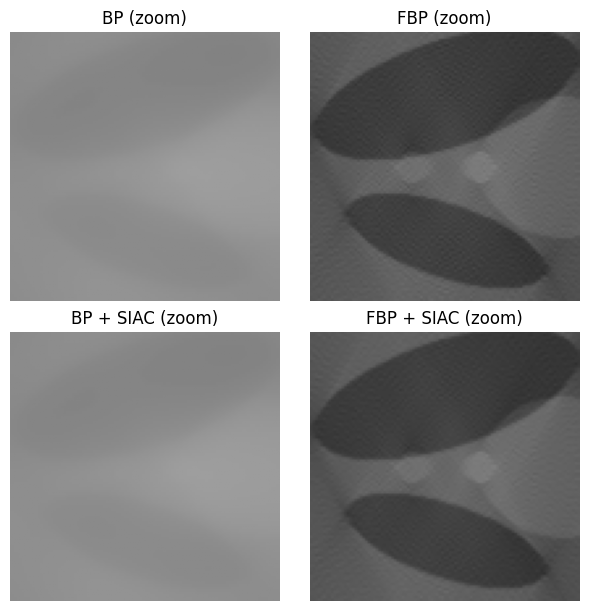

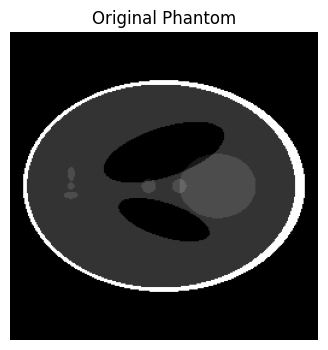

In [3]:
from src.siac_OLD import apply_siac_fft_2d

# dx = space.cell_sides[0]
# dy = space.cell_sides[1]

dx, dy = space.cell_sides   # physical grid spacing (x, y)

img_fbp = fbp.asarray()     # NumPy array with shape (Ny, Nx)
img_bp  = bp.asarray()

moments = 2
BSorder = 2

fbp_siac = apply_siac_fft_2d(img=img_fbp, 
                             dx=dx, dy=dy,
                             moments=moments, BSorder=BSorder, 
                             pad_mode="reflect")

bp_siac = apply_siac_fft_2d(img=img_bp, 
                            dx=dx, dy=dy,
                            moments=moments, BSorder=BSorder, 
                            pad_mode="reflect")


# Plot side by side

# Use consistent intensity scaling
vmin = min(img_bp.min(), img_fbp.min(), bp_siac.min(), fbp_siac.min())
vmax = max(img_bp.max(), img_fbp.max(), bp_siac.max(), fbp_siac.max())


fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

axes[0, 0].imshow(img_bp, cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("BP")
axes[0, 0].axis("off")

axes[1, 0].imshow(bp_siac, cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("BP + SIAC")
axes[1, 0].axis("off")

axes[0, 1].imshow(img_fbp, cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("FBP")
axes[0, 1].axis("off")

axes[1, 1].imshow(fbp_siac, cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("FBP + SIAC")
axes[1, 1].axis("off")

plt.show()

def crop(img, y0, y1, x0, x1):
    return img[y0:y1, x0:x1]

Ny, Nx = img_fbp.shape

# Percentage-based ROI
x0 = int(0.30 * Nx)
x1 = int(0.70 * Nx)
y0 = int(0.30 * Ny)
y1 = int(0.70 * Ny)

fig, axes = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)

axes[0, 0].imshow(crop(img_bp, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("BP (zoom)")
axes[0, 0].axis("off")

axes[1, 0].imshow(crop(bp_siac, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("BP + SIAC (zoom)")
axes[1, 0].axis("off")

axes[0, 1].imshow(crop(img_fbp, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("FBP (zoom)")
axes[0, 1].axis("off")

axes[1, 1].imshow(crop(fbp_siac, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("FBP + SIAC (zoom)")
axes[1, 1].axis("off")

plt.show()


phantom_np = phantom.asarray()

plt.figure(figsize=(4, 4))
plt.imshow(phantom_np, cmap="gray")
plt.title("Original Phantom")
plt.axis("off")
plt.show()




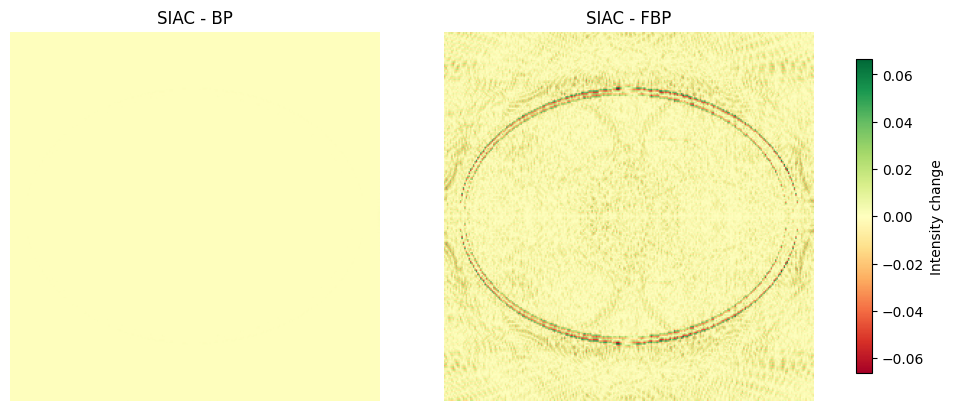

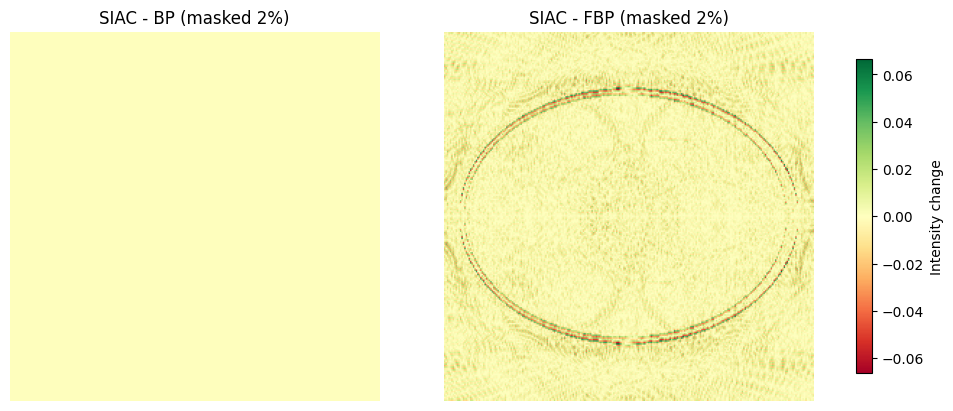

In [4]:

# Difference
diff_bp  = bp_siac  - img_bp
diff_fbp = fbp_siac - img_fbp

max_diff = max(np.abs(diff_bp).max(), np.abs(diff_fbp).max())

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axes[0].imshow(diff_bp, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[0].set_title("SIAC - BP")
axes[0].axis("off")

im1 = axes[1].imshow(diff_fbp, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[1].set_title("SIAC - FBP")
axes[1].axis("off")

fig.colorbar(im1, ax=axes, shrink=0.85, label="Intensity change")
plt.show()


threshold = 0.02 * max_diff   # 2% cutoff
diff_bp_masked = np.where(np.abs(diff_bp) > threshold, diff_bp, 0.0)
diff_fbp_masked = np.where(np.abs(diff_fbp) > threshold, diff_fbp, 0.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axes[0].imshow(diff_bp_masked, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[0].set_title("SIAC - BP (masked 2%)")
axes[0].axis("off")

im1 = axes[1].imshow(diff_fbp_masked, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[1].set_title("SIAC - FBP (masked 2%)")
axes[1].axis("off")

fig.colorbar(im1, ax=axes, shrink=0.85, label="Intensity change")
plt.show()


In [5]:
from src.metrics import removed_energy, rel_l2_err

Ebp, Ebp_rel = removed_energy(img_bp, bp_siac)
Efbp, Efbp_rel = removed_energy(img_fbp, fbp_siac)

print(f"BP:  removed energy = {Ebp:.3e},  relative = {Ebp_rel:.3%}")
print(f"FBP: removed energy = {Efbp:.3e},  relative = {Efbp_rel:.3%}")

e_fbp = rel_l2_err(img_fbp, phantom_np)
e_fbp_siac = rel_l2_err(fbp_siac, phantom_np)

print(f"rel L2 error: FBP={e_fbp:.3%},  FBP+SIAC={e_fbp_siac:.3%}")
print(f"error reduction factor: {e_fbp / e_fbp_siac:.2f}x")


BP:  removed energy = 1.033e-03,  relative = 0.000%
FBP: removed energy = 5.945e+00,  relative = 0.110%
rel L2 error: FBP=51.899%,  FBP+SIAC=51.827%
error reduction factor: 1.00x


## Incorporating Noise

In [6]:
from src.tomo import add_poisson_noise, add_gaussian_noise, add_poisson_gaussian_noise

I0 = 2e4
# sino_noisy = add_poisson_noise(sino, A, I0=I0)
# sino_noisy = add_gaussian_noise(sino, A, I0=I0, sigma=3.0)
sino_noisy = add_poisson_gaussian_noise(sino, A, I0=I0, sigma=2.0)

bp_noisy  = reconstruct_bp(sino_noisy, A)
fbp_noisy = reconstruct_fbp(sino_noisy, A, filter_name=filter_used)

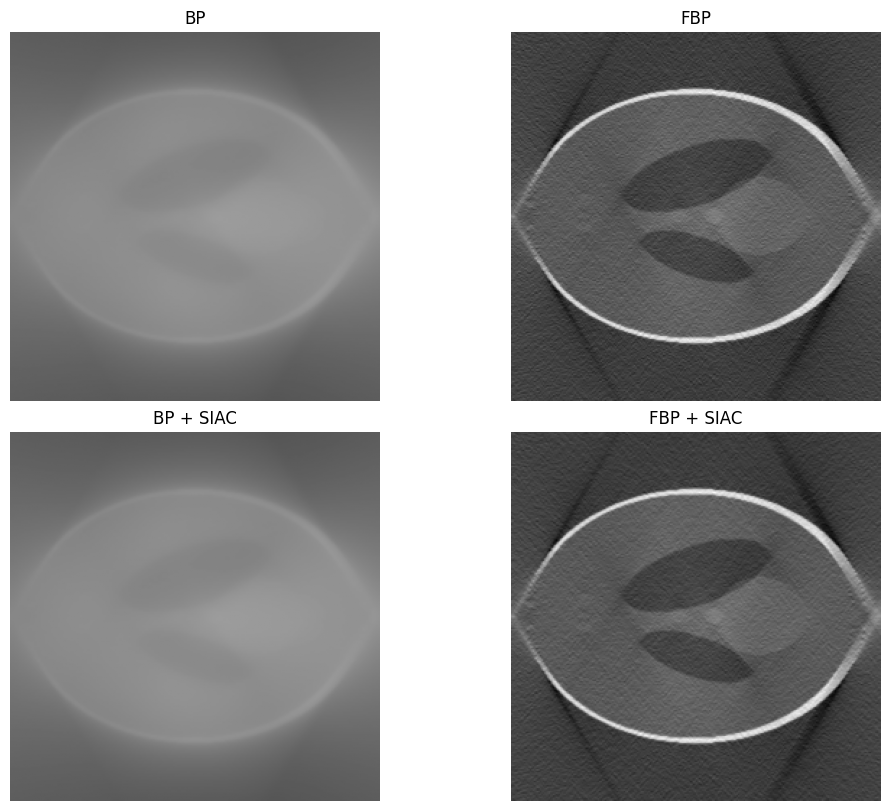

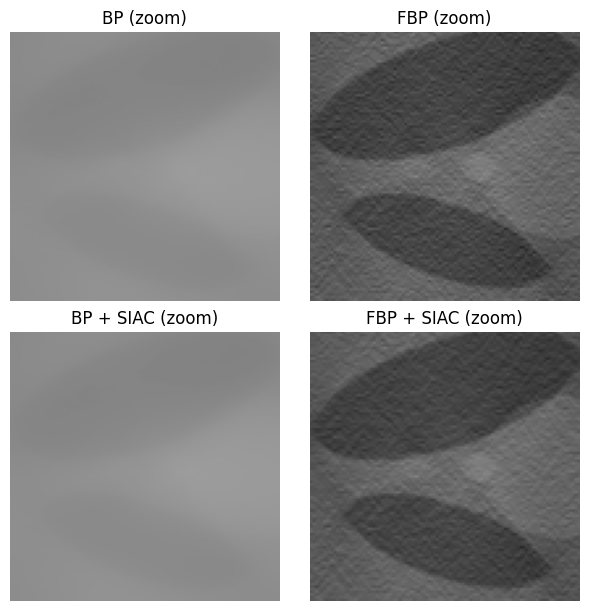

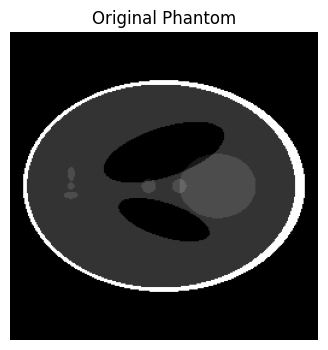

In [7]:
from src.siac_OLD import apply_siac_fft_2d

# dx = space.cell_sides[0]
# dy = space.cell_sides[1]

dx, dy = space.cell_sides   # physical grid spacing (x, y)

img_fbp_noisy = fbp_noisy.asarray()     # NumPy array with shape (Ny, Nx)
img_bp_noisy  = bp_noisy.asarray()

moments = 2
BSorder = 2

fbp_siac_noisy = apply_siac_fft_2d(img=img_fbp_noisy, 
                                dx=dx, dy=dy,
                                moments=moments, BSorder=BSorder, 
                                pad_mode="reflect")

bp_siac_noisy = apply_siac_fft_2d(img=img_bp_noisy, 
                                dx=dx, dy=dy,
                                moments=moments, BSorder=BSorder, 
                                pad_mode="reflect")


# Plot side by side

# Use consistent intensity scaling
vmin = min(img_bp_noisy.min(), img_fbp_noisy.min(), bp_siac_noisy.min(), fbp_siac_noisy.min())
vmax = max(img_bp_noisy.max(), img_fbp_noisy.max(), bp_siac_noisy.max(), fbp_siac_noisy.max())


fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

axes[0, 0].imshow(img_bp_noisy, cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("BP")
axes[0, 0].axis("off")

axes[1, 0].imshow(bp_siac_noisy, cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("BP + SIAC")
axes[1, 0].axis("off")

axes[0, 1].imshow(img_fbp_noisy, cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("FBP")
axes[0, 1].axis("off")

axes[1, 1].imshow(fbp_siac_noisy, cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("FBP + SIAC")
axes[1, 1].axis("off")

plt.show()

Ny, Nx = img_fbp_noisy.shape

# Percentage-based ROI
x0 = int(0.30 * Nx)
x1 = int(0.70 * Nx)
y0 = int(0.30 * Ny)
y1 = int(0.70 * Ny)

fig, axes = plt.subplots(2, 2, figsize=(6, 6), constrained_layout=True)

axes[0, 0].imshow(crop(img_bp_noisy, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 0].set_title("BP (zoom)")
axes[0, 0].axis("off")

axes[1, 0].imshow(crop(bp_siac_noisy, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 0].set_title("BP + SIAC (zoom)")
axes[1, 0].axis("off")

axes[0, 1].imshow(crop(img_fbp_noisy, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[0, 1].set_title("FBP (zoom)")
axes[0, 1].axis("off")

axes[1, 1].imshow(crop(fbp_siac_noisy, y0, y1, x0, x1),
                  cmap="gray", vmin=vmin, vmax=vmax)
axes[1, 1].set_title("FBP + SIAC (zoom)")
axes[1, 1].axis("off")

plt.show()


phantom_np = phantom.asarray()

plt.figure(figsize=(4, 4))
plt.imshow(phantom_np, cmap="gray")
plt.title("Original Phantom")
plt.axis("off")
plt.show()




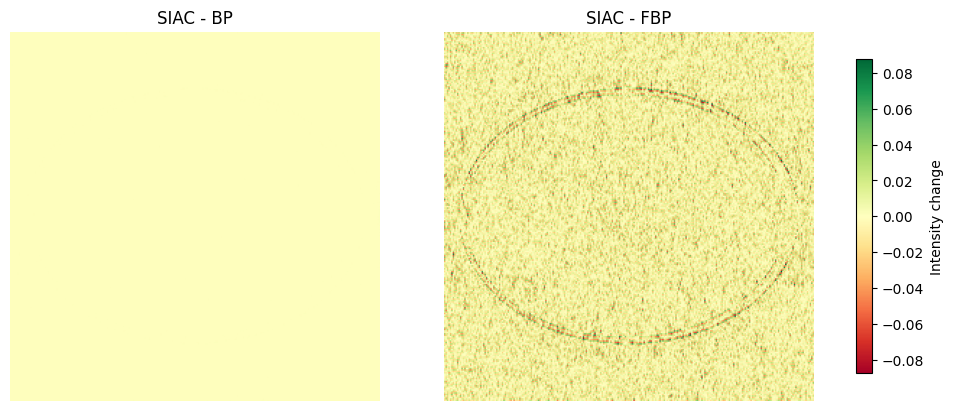

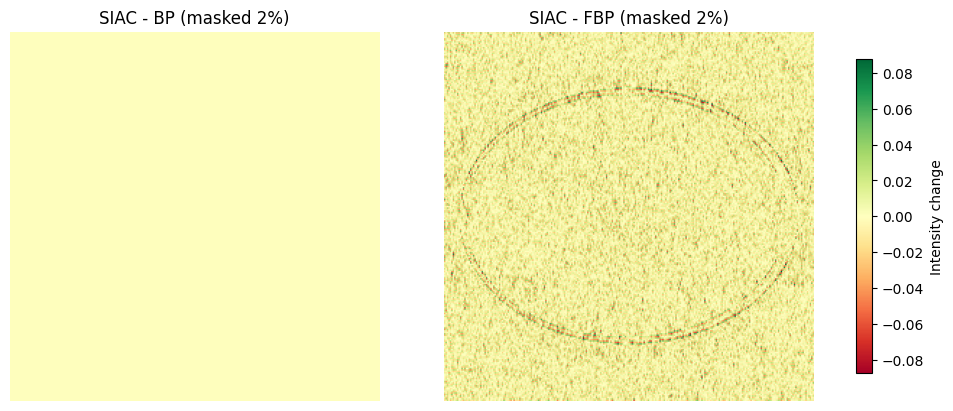

In [8]:

# Difference
diff_bp_noisy  = bp_siac_noisy  - img_bp_noisy
diff_fbp_noisy = fbp_siac_noisy - img_fbp_noisy

max_diff = max(np.abs(diff_bp_noisy).max(), np.abs(diff_fbp_noisy).max())

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axes[0].imshow(diff_bp_noisy, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[0].set_title("SIAC - BP")
axes[0].axis("off")

im1 = axes[1].imshow(diff_fbp_noisy, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[1].set_title("SIAC - FBP")
axes[1].axis("off")

fig.colorbar(im1, ax=axes, shrink=0.85, label="Intensity change")
plt.show()


threshold = 0.02 * max_diff   # 2% cutoff
diff_bp_noisy_masked = np.where(np.abs(diff_bp_noisy) > threshold, diff_bp_noisy, 0.0)
diff_fbp_noisy_masked = np.where(np.abs(diff_fbp_noisy) > threshold, diff_fbp_noisy, 0.0)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = axes[0].imshow(diff_bp_noisy_masked, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[0].set_title("SIAC - BP (masked 2%)")
axes[0].axis("off")

im1 = axes[1].imshow(diff_fbp_noisy_masked, cmap="RdYlGn", vmin=-max_diff, vmax=max_diff)
axes[1].set_title("SIAC - FBP (masked 2%)")
axes[1].axis("off")

fig.colorbar(im1, ax=axes, shrink=0.85, label="Intensity change")
plt.show()


In [9]:
from src.metrics import removed_energy, rel_l2_err

Ebp, Ebp_rel = removed_energy(img_bp_noisy, bp_siac_noisy)
Efbp, Efbp_rel = removed_energy(img_fbp_noisy, fbp_siac_noisy)

print(f"BP:  removed energy = {Ebp:.3e},  relative = {Ebp_rel:.3%}")
print(f"FBP: removed energy = {Efbp:.3e},  relative = {Efbp_rel:.3%}")

e_fbp = rel_l2_err(img_fbp_noisy, phantom_np)
e_fbp_siac = rel_l2_err(fbp_siac_noisy, phantom_np)

print(f"rel L2 error: FBP={e_fbp:.3%},  FBP+SIAC={e_fbp_siac:.3%}")
print(f"error reduction factor: {e_fbp / e_fbp_siac:.2f}x")


BP:  removed energy = 3.067e-03,  relative = 0.000%
FBP: removed energy = 2.052e+01,  relative = 0.362%
rel L2 error: FBP=57.506%,  FBP+SIAC=55.692%
error reduction factor: 1.03x


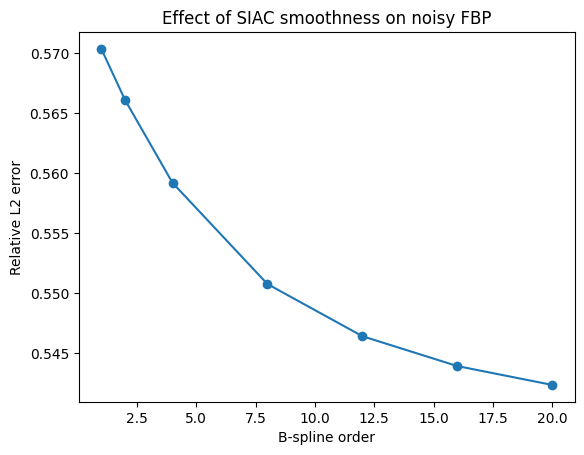

In [10]:
BSorders = [1, 2, 4, 8, 12, 16, 20]
errs = []

for n in BSorders:
    fbp_s = apply_siac_fft_2d(img_fbp_noisy, dx, dy, moments=6, BSorder=n)
    errs.append(rel_l2_err(fbp_s, phantom_np))

plt.plot(BSorders, errs, marker="o")
plt.xlabel("B-spline order")
plt.ylabel("Relative L2 error")
plt.title("Effect of SIAC smoothness on noisy FBP")
plt.show()


### Testing the new functions vs old
* **New**: Applies the SIAC filter axes-wise
* **Old**: Applied the SIAC using tensor products

* **Note**: The old code can be useful if we only consider the image space, but the new one is more flexible, can be applied in data space (to sinograms) aswell, where we would want to apply to the detector axis only (probably)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from src.siac_OLD import apply_siac_fft_2d
from src.siac import apply_siac_fft_nd

def run_siac_pair(img, dx, dy, moments, BSorder, pad_mode):
    old = apply_siac_fft_2d(img=img, dx=dx, dy=dy, moments=moments, BSorder=BSorder, pad_mode=pad_mode)
    new = apply_siac_fft_nd(img, h_per_axis=(dy, dx), axes=(0, 1), moments=moments, BSorder=BSorder, pad_mode=pad_mode)
    return old, new

def compare_and_plot(old, new, title, zoom_frac=(0.30, 0.70), show_zoom=True):
    diff = new - old

    # metrics
    max_abs = np.max(np.abs(diff))
    l2 = np.linalg.norm(diff)
    rel_l2 = l2 / np.linalg.norm(old)

    print(f"\n{title}")
    print("-" * 50)
    print("max abs diff :", max_abs)
    print("L2 norm diff :", l2)
    print("relative L2  :", rel_l2)

    # plots
    vmax = max(np.abs(old).max(), np.abs(new).max())
    fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    axes[0].imshow(old, cmap="gray", vmin=-vmax, vmax=vmax); axes[0].set_title(f"{title} - OLD"); axes[0].axis("off")
    axes[1].imshow(new, cmap="gray", vmin=-vmax, vmax=vmax); axes[1].set_title(f"{title} - NEW"); axes[1].axis("off")
    im = axes[2].imshow(diff, cmap="seismic"); axes[2].set_title("NEW - OLD"); axes[2].axis("off")
    plt.show()

    if show_zoom:
        Ny, Nx = old.shape
        a, b = zoom_frac
        x0, x1 = int(a*Nx), int(b*Nx)
        y0, y1 = int(a*Ny), int(b*Ny)

        plt.figure(figsize=(4,4))
        plt.imshow(diff[y0:y1, x0:x1], cmap="seismic")
        plt.colorbar()
        plt.title(f"{title}: diff zoom")
        plt.axis("off")
        plt.show()
        

def diff_diagnostics(old, new, border=40, name=""):
    diff = new - old
    Ny, Nx = diff.shape

    border = min(border, Ny//2 - 1, Nx//2 - 1)
    inner = diff[border:Ny-border, border:Nx-border]
    old_inner = old[border:Ny-border, border:Nx-border]

    print(f"\n{name} (border={border})")
    print("max abs diff (full)   :", np.max(np.abs(diff)))
    print("L2 diff (full)        :", np.linalg.norm(diff))
    print("max abs diff (inner)  :", np.max(np.abs(inner)))
    print("L2 diff (inner)       :", np.linalg.norm(inner))
    print("rel L2 (inner vs old) :", np.linalg.norm(inner) / np.linalg.norm(old_inner))

def assert_close(old, new, rtol=1e-12, atol=1e-12, name=""):
    ok = np.allclose(old, new, rtol=rtol, atol=atol)
    print(f"{name} allclose(rtol={rtol}, atol={atol}):", ok)
    if not ok:
        diff = new - old
        raise AssertionError(f"{name} failed: max abs diff = {np.max(np.abs(diff))}")



FBP + SIAC
--------------------------------------------------
max abs diff : 8.881784197e-16
L2 norm diff : 3.08866038223e-14
relative L2  : 4.14557083805e-16


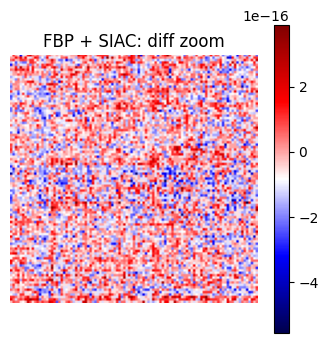


BP + SIAC
--------------------------------------------------
max abs diff : 1.11022302463e-15
L2 norm diff : 6.03413171888e-14
relative L2  : 4.23720379248e-16


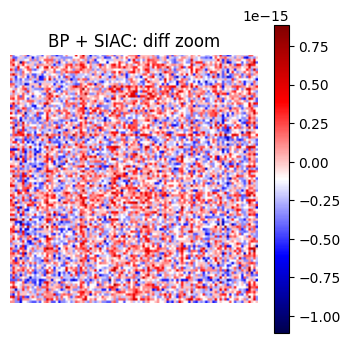


FBP + SIAC (border=40)
max abs diff (full)   : 8.881784197e-16
L2 diff (full)        : 3.08866038223e-14
max abs diff (inner)  : 8.881784197e-16
L2 diff (inner)       : 2.43196290441e-14
rel L2 (inner vs old) : 3.75762887895e-16

BP + SIAC (border=40)
max abs diff (full)   : 1.11022302463e-15
L2 diff (full)        : 6.03413171888e-14
max abs diff (inner)  : 1.11022302463e-15
L2 diff (inner)       : 4.63630118757e-14
rel L2 (inner vs old) : 3.9524399286e-16
FBP+SIAC allclose(rtol=1e-12, atol=1e-12): True
BP+SIAC allclose(rtol=1e-12, atol=1e-12): True


In [12]:
dx, dy = space.cell_sides   # (dx, dy)

moments = 2
BSorder = 2

fbp_siac_old, fbp_siac_new = run_siac_pair(img_fbp_noisy, dx, dy, moments, BSorder, "reflect")
bp_siac_old,  bp_siac_new  = run_siac_pair(img_bp_noisy,  dx, dy, moments, BSorder, "reflect")

compare_and_plot(fbp_siac_old, fbp_siac_new, "FBP + SIAC")
compare_and_plot(bp_siac_old,  bp_siac_new,  "BP + SIAC")

diff_diagnostics(fbp_siac_old, fbp_siac_new, border=40, name="FBP + SIAC")
diff_diagnostics(bp_siac_old,  bp_siac_new,  border=40, name="BP + SIAC")

assert_close(fbp_siac_old, fbp_siac_new, rtol=1e-12, atol=1e-12, name="FBP+SIAC")
assert_close(bp_siac_old,  bp_siac_new,  rtol=1e-12, atol=1e-12, name="BP+SIAC")
